In [24]:
import os 
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as T
import torch.nn.functional as F 
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader 
from torchvision.io import read_image

from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

plt.rcParams["savefig.bbox"] = 'tight'
torch.manual_seed(0)

In [25]:
transforms = nn.Sequential(
    T.Resize((224, 224))
)

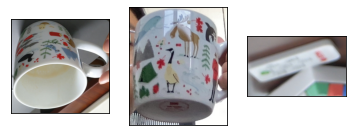

In [26]:
def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = T.ToPILImage()(img.to('cpu'))
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
a = read_image(str(Path('data/images/train/') / 'anchor0.jpg'))
p = read_image(str(Path('data/images/train/') / 'positive0.jpg'))
n = read_image(str(Path('data/images/train/') / 'negative0.jpg'))

show([a, p, n])

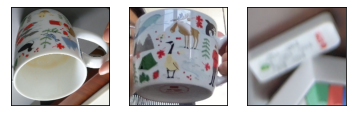

In [27]:
a_t = transforms(a)
p_t = transforms(p)
n_t = transforms(n)

show([a_t, p_t, n_t])

In [28]:
# configurations 
DATA_DIR = '/data/images/'

BATCH_SIZE = 32
LR = 0.001 
EPOCHS = 15 

DEVICE = 'cpu'

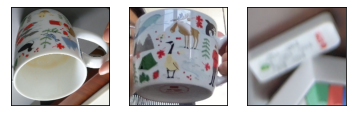

In [29]:
class APN_Dataset(Dataset): 
  def __init__(self, train=True): 
    if train: 
      self.data_dir = "." + DATA_DIR + "train/"
    else: 
      self.data_dir = "." + DATA_DIR + "test/"

  def __len__(self): 
    return len(os.listdir(self.data_dir)) // 3

  def __getitem__(self, idx): 
    A_img = transforms(read_image(self.data_dir + "anchor" + str(idx) + ".jpg"))
    P_img = transforms(read_image(self.data_dir + "positive" + str(idx) + ".jpg"))
    N_img = transforms(read_image(self.data_dir + "negative" + str(idx) + ".jpg"))

    return A_img, P_img, N_img

train = APN_Dataset()
idx = 0
A, P, N = train[idx]
show([A, P, N])

In [30]:
class APN_Model(nn.Module):
  
  def __init__(self, emb_size = 2): 
    super(APN_Model, self).__init__()

    self.weights = EfficientNet_V2_S_Weights.IMAGENET1K_V1
    self.siamese = efficientnet_v2_s(weights=self.weights)
    self.siamese.classifier = nn.Linear(in_features=self.siamese.classifier[1].in_features, out_features=emb_size)

  def forward(self, img1, img2): 
    preprocess = self.weights.transforms()
    x1 = preprocess(img1).unsqueeze(0)
    x2 = preprocess(img2).unsqueeze(0)
    out1 = self.siamese(x1)
    out2 = self.siamese(x2)
    return out1, out2

In [31]:
model = APN_Model()
model.to(DEVICE)
model.eval()

APN_Model(
  (siamese): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24

In [32]:
SIMILIARITY_THRESHOLD = 0.3

In [33]:
out1, out2 = model(A, P)
dist = F.pairwise_distance(out1, out2, keepdim = True)
print(f"Same object? : {(dist<SIMILIARITY_THRESHOLD).item()} with dissimiliarity score of {dist.item()}")

Same object? : True with dissimiliarity score of 0.0937592089176178


In [34]:
out1, out2 = model(A, N)
dist = F.pairwise_distance(out1, out2)
print(f"Same object? : {(dist<SIMILIARITY_THRESHOLD).item()} with dissimiliarity score of {dist.item()}")

Same object? : False with dissimiliarity score of 0.4228082597255707
